In [11]:
import math
import numpy
import torch
import torch.nn as nn
import matplotlib.pyplot

In [12]:
def rope_ntk_spectrum(seq_len=2048, head_dim=128, base=10_000, rescale=1.0, device="cuda", drop_imag=True):
    """
    Returns eigen-values of the NTK Gram matrix for RoPE features.
    rescale = 1.0  → original base
              8.0  → NTK-aware stretch factor
        # quick demo
    L = 2048
    lam_orig = rope_ntk_spectrum(L, rescale=1.0)
    lam_stretch = rope_ntk_spectrum(L, rescale=8.0)
    print("Top-10 eigen-values:")
    print("original :", lam_orig[:10].tolist())
    print("NTK 8  :", lam_stretch[:10].tolist())
    """
    base = base * (rescale ** (head_dim / (head_dim - 2)))
    inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2, device=device).float() / head_dim))
    t = torch.arange(seq_len, dtype=torch.float, device=device)
    _scale = "" if rescale == 1 else f", rescaled {rescale}"
    print(f"Computing spectrum of RoPE, context: {seq_len}, model_dim {head_dim}{_scale}, base {int(base):,}")
    # phase matrix  (seq_len, head_dim//2)
    phases = t.outer(inv_freq)                     # ω_k * t
    # complex features  e^{i ω_k t}
    z = torch.polar(torch.ones_like(phases), phases)        # (T, d/2)
    print(f" invfreq plane {tuple(phases.shape)}, e**(i*f**(-1)) {tuple(z.shape)}, {z.dtype}")
    # analytic NTK Gram matrix  G_{i,j} = Re[ <z_i, z_j> ]  (real part)
    G = z.conj().T @ z
    # G = z @ z.conj().T
    # eigen-decompose
    _G = G.real if drop_imag else G
    lam, _ = torch.linalg.eigh(_G)
    print(f" Gram matrix G = z*.T @ z, shape {tuple(G.shape)}, Eigen values {tuple(lam.shape)}")
    return lam.sort(descending=True)[0].cpu()


In [13]:
seq = 2048
train_eig = rope_ntk_spectrum(seq)
test_eig8X = rope_ntk_spectrum(seq*8)
test_eig8XNTK = rope_ntk_spectrum(seq*8, rescale=8)

Computing spectrum of RoPE, context: 2048, model_dim 128, base 10,000
 invfreq plane (2048, 64), e**(i*f**(-1)) (2048, 64), torch.complex64
 Gram matrix G = z*.T @ z, shape (64, 64), Eigen values (64,)
Computing spectrum of RoPE, context: 16384, model_dim 128, base 10,000
 invfreq plane (16384, 64), e**(i*f**(-1)) (16384, 64), torch.complex64
 Gram matrix G = z*.T @ z, shape (64, 64), Eigen values (64,)
Computing spectrum of RoPE, context: 16384, model_dim 128, rescaled 8, base 82,684
 invfreq plane (16384, 64), e**(i*f**(-1)) (16384, 64), torch.complex64
 Gram matrix G = z*.T @ z, shape (64, 64), Eigen values (64,)


In [14]:
print(f"EV train {len(train_eig)}")
print(f"EV test {len(test_eig8XNTK)}")

EV train 64
EV test 64


## Pearson correlation between paired datasets -> covariance
$$\Lambda_x =\{\lambda_{x_1},...,\lambda_{x_n}\}, \quad \Lambda_y=\{\lambda_{y_1},...,\lambda_{y_n}\}, $$
$$\lambda_{xc_i} = \lambda_{x_i} - \bar{\lambda_x},\qquad \lambda_{yc_i} = \lambda_{y_i} - \bar{\lambda_y}$$
$$\rho = \frac{\sum_{i=1}^n\lambda_{xc_i}\lambda_{yc_i}}{\sqrt{\sum_{i=1}^n\lambda_{xc_i}^2}  \sqrt{\sum_{i=1}^n\lambda_{yc_i}^2} }$$

In [17]:
def pearson(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    _x = x - x.mean()
    _y = y - y.mean()
    _d = _x.norm(p=2) * _y.norm(p=2)
    if _d == 0:
        return _d
    return (_x @ _y)/_d

def torch_pearson(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    #  2x2 correlation matrix
    #    [[corr(L, L),   corr(L, L8x)],   # -> single corner suffices
    #     [corr(L8x, L), corr(L8x, L8x)]]
    return round(torch.corrcoef(torch.stack([x, y]))[0, 1].cpu().item(), 4)

print(pearson(train_eig, test_eig8XNTK), pearson(train_eig, test_eig8X))

print(torch_pearson(train_eig, test_eig8XNTK))
print(torch_pearson(train_eig, test_eig8X))


tensor(0.9909) tensor(0.9204)
0.9909
0.9204


torch.Size([12])


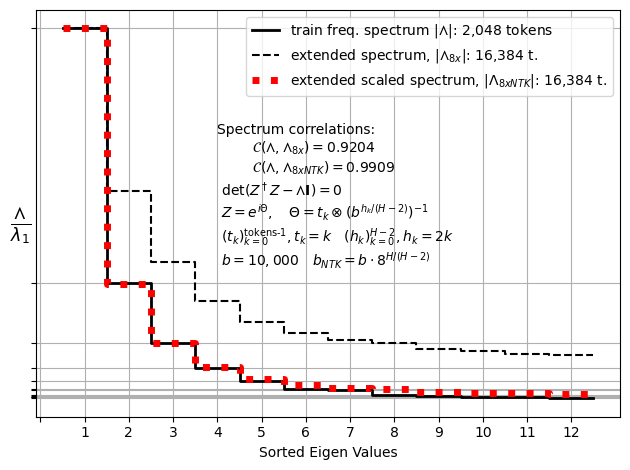

In [18]:
def _base(x):
    return np.concatenate([x[0:1], x])

def plot_spectra(train_eig, test_eig8X, test_eig8XNTK, show=True, steps=8, norm=True, **kwargs):
    steps = steps or len(train_eig)
    x = np.arange(-1, steps)

    l = train_eig[:steps].clone()
    l8X = test_eig8X[:steps].clone()
    l8XNTK = test_eig8XNTK[:steps].clone()
    print(l.shape)
    if norm:
        l = l/l[0]
        l8X = l8X/l8X[0]
        l8XNTK = l8XNTK/l8XNTK[0]
    
    plt.step(x+0.5, _base(l),
             linewidth = 2, color = 'black', label="train freq. spectrum $|\\mathbb{\\Lambda}|$: "+f"{seq:,} tokens")
    plt.step(x+0.5, _base(l8X), color="black", linestyle="--",
             label="extended spectrum, $|\\mathbb{\\Lambda}_{8x}|$:"+f" {seq*8:,} t.")
    plt.step(x+0.5, _base(l8XNTK), linewidth = 5, color = 'red', alpha = 1, linestyle=":",
             label="extended scaled spectrum, $|\\Lambda_{8xNTK}|$:"+f" {seq*8:,} t.")
    text = "Spectrum correlations:"
    text += "\n\t$\\mathcal{C}(\\mathbb{\\Lambda},\\mathbb{\\Lambda}_{8x}) = $" + f"{torch_pearson(train_eig, test_eig8X)}"
    text += "\n\t$\\mathcal{C}(\\mathbb{\\Lambda},\\mathbb{\\Lambda}_{8xNTK}) = $"+ f"{torch_pearson(train_eig, test_eig8XNTK)}"
    text += "\n $\\det(Z^\\dagger Z - \\mathbb{\\Lambda} \\mathbf{I}) = 0$"
    text += "\n $ Z = e^{i\\Theta},\\quad \\Theta = t_k \\otimes (b^{h_k/(H-2)})^{-1}$"
    text += "\n $ (t_k)_{k =0}^{\\text{tokens-1}},t_k=k \\quad (h_k)_{k=0}^{H-2}, h_k=2k$"
    text += "\n $ b=10,000\\quad b_{NTK} = b \\cdot 8 ^{H/(H-2)}$"
    
    plt.text(3, 0.4, s=text)
    #\\cross \\log(1-1\\times 10^{-4}
    plt.xlabel("Sorted Eigen Values")
    ylabel = plt.ylabel("$\\frac{\\mathbb{\\Lambda}}{\\lambda_1}$", rotation=0, fontsize=18)
    ylabel.set_position((-1.3,0.42))
    labels = (x + 1).tolist()
    labels[0] = ""
    plt.xticks(x, labels)
    plt.yticks(l, [""]*len(l))
    plt.grid()
    plt.legend(loc="upper right")

    if show:
        plt.tight_layout()
        if 'save' in kwargs:
            plt.savefig(kwargs['save'])
        plt.show()
plot_spectra(train_eig, test_eig8X, test_eig8XNTK, steps=12)

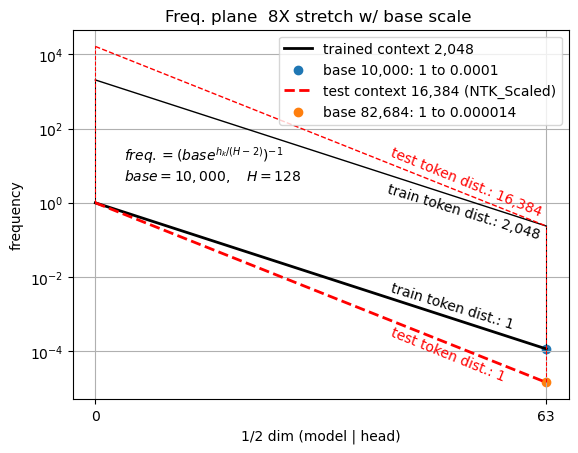

In [19]:
def plot_ntk_scaling_plane(dim=128, emb=2048, scale=8, base=10_000, show=True, **kwargs):
    """
    frequency plane
    NTK-aware scaling keeps the eigen-spectrum of the neural tangent kernel (the Gram matrix of gradients) unchanged 
    rotation-based feature φ(θ) = e^{i θ} the NTK at position t is built from
        ∂f/∂θ · ∂f/∂θ' ∝ cos(θ_t - θ_{t'}).
    Training  lenght L the distribution of angular differences Δ = |t - t'| spans [0, L].
    Inference:  L = λL (λ = 8) same distribution of phase difference: invariant kernel eigenvalues
    ntk compresses the lowest frequencies ( last embedding pos)
    """
    plt.title("Freq. plane " +f" {scale}X stretch w/ base scale ")
    idcs = torch.arange(0,dim, 2)
    iff = 1.0 / (base ** (idcs.float() / dim))
    plt.plot(iff, linestyle="-", color="black", linewidth=2, label=f"trained context {emb:,}")
    plt.plot(iff*emb, linestyle="-",color="black", linewidth=1)#, label=f"trained at {emb}, tokens{dim-2, dim-1}")
    plt.plot([0,0], [1,emb], color="black", linewidth=0.75)
    plt.plot([dim//2-1, dim//2-1], [iff[-1],iff[-1]*emb], color="black", linewidth=0.75)
    plt.scatter(dim//2 -1, iff[-1].item(), label=f"base {base:,}: 1 to {iff[-1]:.4f}" )
    # NTK scalking to keep eigenvalues similar
    basentk = base* 8 **(dim/(dim-2))
    iff8 = 1.0 / (basentk ** (idcs.float() / dim))
    plt.plot(iff8, color="red", linestyle="--",  linewidth=2,  label=f"test context {emb*scale:,} (NTK_Scaled)")
    plt.plot(iff8*emb*scale, color='red', linestyle="--", linewidth=1)# label=f"NTK scaled, test at {emb*scale}, tokens{dim-2, dim-1}")
    plt.plot([0,0], [iff8[0], iff8[0]*emb*scale], color="red", linestyle="--", linewidth=0.75)
    plt.plot([dim//2-1, dim//2-1], [iff8[-1], iff8[-1]*emb*scale], color="red", linestyle="--", linewidth=0.75)
    plt.scatter(dim//2 -1, iff8[-1].item(), label=f"base {int(basentk):,}: 1 to {iff8[-1]:.6f}" )
    texts=kwargs.get("texts", [f"test token dist.: {2048*8:,}", f"train token dist.: {2048:,}", "test token dist.: 1", "train token dist.: 1"])
    poss=kwargs.get("poss", [(41, 0.45), (40.5, 0.11), (41, 1.6e-5), (41, 4e-4)])
    rots=kwargs.get("rots", [-22, -17, -22, -17])
    colorss=kwargs.get("colorss", ['red', 'black', 'red', 'black'])
    assert len(texts) == len(poss) == len(rots), f"{texts}, {poss}, {rots} must be of equal len"
    # plt.text(47, 0, s=f"{2048*8:,}th token", rotation=-22, color="red")
    # plt.text(47,-2, s=f"{2048:,}th token", rotation=-18, color="black")
    plt.text(4,4, s="$freq.=(base^{h_k/(H-2)})^{-1}$\n$base=10,000,\\quad H=128$")
    for i, txt in enumerate(texts):
        kw = {}
        if len(colorss) > i:
            kw['color'] = colorss[i]
        plt.text(poss[i][0], poss[i][1], s=txt, rotation=rots[i], **kw)
    plt.legend()
    plt.xticks([0, dim//2 - 1])
    plt.xlabel("1/2 dim (model | head)")
    plt.ylabel("frequency")
    plt.grid();plt.yscale('log')
    if show:
        plt.show()
plot_ntk_scaling_plane()

torch.Size([10])


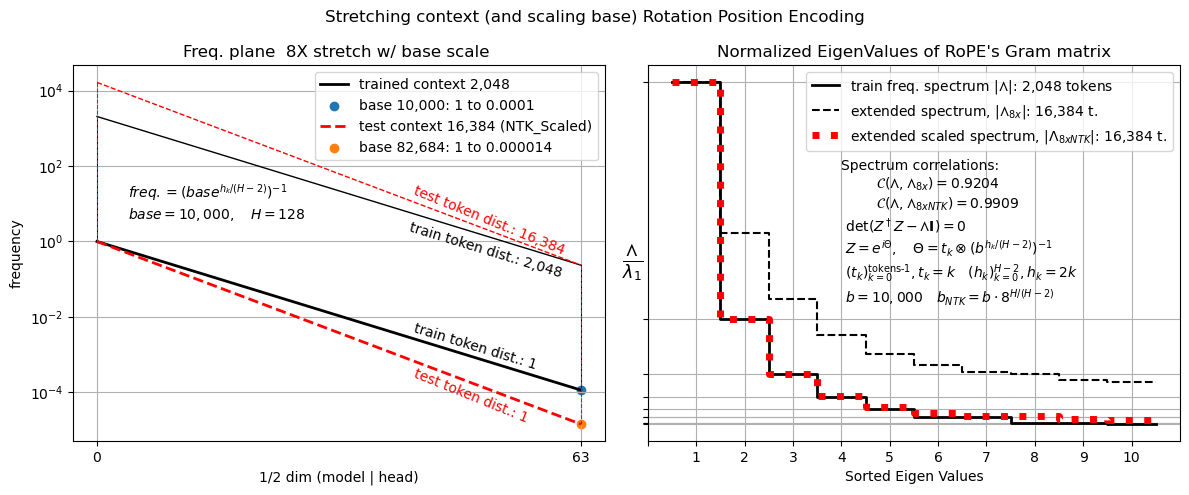

In [20]:
plt.figure(figsize=(12,5))
plt.suptitle("Stretching context (and scaling base) Rotation Position Encoding")
plt.subplot(121)

plot_ntk_scaling_plane(show=False)
plt.subplot(122)
plt.title("Normalized EigenValues of RoPE's Gram matrix")
plot_spectra(train_eig, test_eig8X, test_eig8XNTK, steps=10, save="RoPE_scale.png")
# plot_spectra(save="RoPE_scale.png")


## token order
$$(t_k)_{k =0}^{\text{tokens}-1}, \quad t_k = k.\qquad \text{t=torch.arange(seq\_len, dtype=torch.float, device=device)\# t: token position}$$

## head dimension
$$(h_k)_{k =0}^{H-2}, \quad h_k = 2k, \qquad H = 128\qquad \text{H: head dimension, }h_k\text{: embedding vector}$$

## frequency
$$f = b^{h_k/(H-2)},\qquad b = 10,000.\qquad \text{f=b**(torch.arange(0, H, 2, device=device).float() / (H-2))}$$

## outer product, phases
$$ \Theta = t_k \otimes f^{-1}.\qquad\text{phases = t.outer(1/f)}$$

## polar angle matrix
$$Z = e^{i\Theta},\qquad\text{Z = torch.polar(torch.ones\_like(phases), phases)}$$

## Gram Matrix
$$G=Z^\dagger Z$$

## Eigen Values $\lambda$
$$\det(G - \lambda I) = 0$$


$$\det(Z^\dagger Z - \lambda I) = 0$$
$$\det( e^{i\Theta \dagger}  e^{i\Theta} - \lambda I) = 0$$
$$ \Theta = t_k \otimes \frac{1}{b^{h_k/(H-2)}}. \qquad Z =e^{i (t_k \otimes \frac{1}{b^{h_k/(H-2)}})}$$


In [21]:
train_eigi = rope_ntk_spectrum(seq, drop_imag=False)
test_eig8Xi = rope_ntk_spectrum(seq*8, drop_imag=False)
test_eig8XNTKi = rope_ntk_spectrum(seq*8, rescale=8, drop_imag=False)

Computing spectrum of RoPE, context: 2048, model_dim 128, base 10,000
 invfreq plane (2048, 64), e**(i*f**(-1)) (2048, 64), torch.complex64
 Gram matrix G = z*.T @ z, shape (64, 64), Eigen values (64,)
Computing spectrum of RoPE, context: 16384, model_dim 128, base 10,000
 invfreq plane (16384, 64), e**(i*f**(-1)) (16384, 64), torch.complex64
 Gram matrix G = z*.T @ z, shape (64, 64), Eigen values (64,)
Computing spectrum of RoPE, context: 16384, model_dim 128, rescaled 8, base 82,684
 invfreq plane (16384, 64), e**(i*f**(-1)) (16384, 64), torch.complex64
 Gram matrix G = z*.T @ z, shape (64, 64), Eigen values (64,)


## Eigen values of $Re(G)^T Re(G) \approx G^{\dagger} G, \quad G \in \mathbb{C}.$

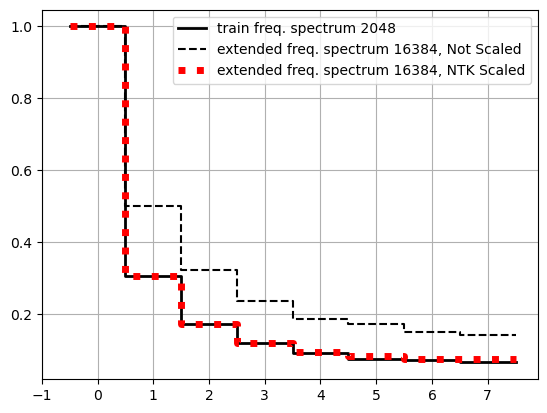

In [22]:
steps  = 8
x = np.arange(-1, steps)
plt.step(x+0.5, _base(train_eigi[:steps])/train_eigi[0],
         linewidth = 2, color = 'black', label=f"train freq. spectrum {seq}")
plt.step(x+0.5, _base(test_eig8Xi[:steps])/test_eig8Xi[0], color="black", linestyle="--",
         label=f"extended freq. spectrum {8*seq}, Not Scaled")
plt.step(x+0.5, _base(test_eig8XNTKi[:steps])/test_eig8XNTKi[0], linewidth = 5, color = 'red', alpha = 1, linestyle=":",
         label=f"extended freq. spectrum {8*seq}, NTK Scaled")
plt.xticks(x)
plt.grid()
plt.legend()
plt.show()

In [23]:
def plot_freq(d_model, tohens, yscale='log', show = True):
    """plots position embedding coefficients for token """
    pos = torch.arange(0, tohens).unsqueeze(1).float()
    div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
    # plt.figure(figsize=(8,4))
    # plt.subplot(121)

    for i in range(2, 511):
        plt.plot(div*i, color="black", linewidth=0.2, alpha = 0.5);
    plt.yscale(yscale);plt.grid();plt.legend(title=f"e.g. seq len = {tohens}");plt.xticks([0, d_model//2-1], [0, f"{d_model//2-1}\n(d_model/2)"]);plt.xlabel("half Embedding depth");
    plt.plot(div*1, label="$\\theta$s for token[1]", markevery=[0, d_model//2-1], marker='o');
    plt.plot(div*3, label="$\\theta$s for token[3]", markevery=[0, d_model//2-1], marker='o');
    plt.plot(div*tohens, label="$\\theta$s for token[511]",  markevery=[0, d_model//2-1], marker='o', zorder=2);
    plt.legend()
    # plt.subplot(122)
    # plt.plot(div, label="$\\theta$s for token[0]", markevery=[0, 127], marker='o');plt.plot(div*512, label="$\\theta$s for token[511]",  markevery=[0, 127], marker='o');plt.yscale('log');plt.grid();plt.legend(title="e.g. seq len = 512");plt.xticks([0, 127], [0, "127\n(d_model/2)"]);plt.xlabel("half Embedding depth");
    plt.tight_layout()
    if show:
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_298768/3332348833.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.yscale(yscale);plt.grid();plt.legend(title=f"e.g. seq len = {tohens}");plt.xticks([0, d_model//2-1], [0, f"{d_model//2-1}\n(d_model/2)"]);plt.xlabel("half Embedding depth");


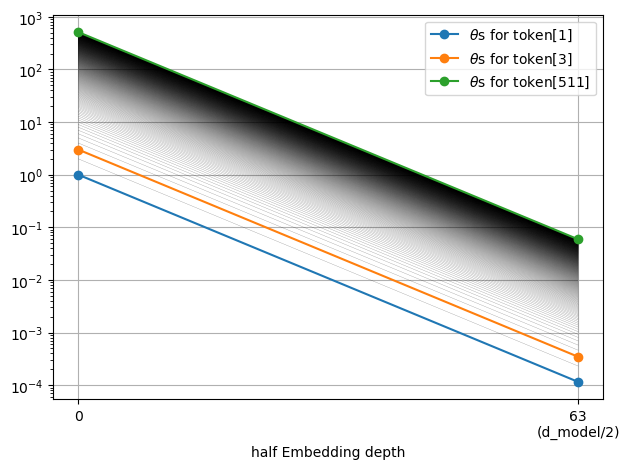

In [24]:
plot_freq(128,512, 'log')

In [25]:
class PositionalEncoding(nn.Module):
    """ max_length of tokens, in this case if max_tokens are 64, thats all one needs
    .pe.shape = [1, max_len, model_d]
    """
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # (max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() *
                        -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0)) # (1, max_len, d_model)
        self.max_len = max_len
        self.d_model = d_model
    def forward(self, x):          # x: (batch, seq, d_model)
        return x + self.pe[:, :x.size(1)]
    def show(self, **kwargs):
        import matplotlib.pyplot as plt
        if "figsize" in kwargs:
            plt.figure(figsize=kwargs['figsize'])
        plt.imshow(self.pe[0].T.numpy())
        plt.title("pos encoding: sin(pos*freq$^{-1}$),cos(pos*freq$^{-1}$)")
        plt.xlabel("token positions")
        plt.ylabel("d_model")
        # plt.ylabel("d_model: div = log interp(1 to 1e-4)")
        plt.xticks([0,self.max_len-1])
        plt.yticks([0,self.d_model-1])
        plt.tight_layout()
        if 'save' in kwargs:
            plt.savefig(kwargs['save'])
        plt.show()

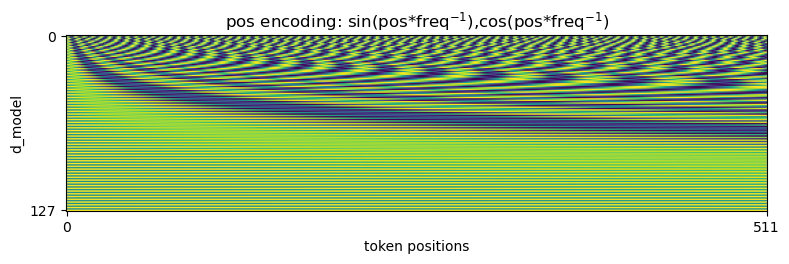

In [26]:
P = PositionalEncoding(128, 512)
P.show(figsize=(8,4), save="pos_enc.png")

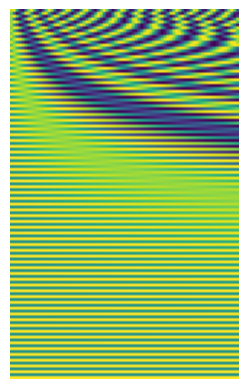

In [38]:
# plt.figure(figsize=(1,2))
plt.imshow(P.pe[0].T.numpy()[:,1:80])
plt.axis('off')
plt.savefig("pe_slice.png")
plt.show()

In [1]:
from minitransformer import Tok

In [8]:
x = "The cat ate the hat on the mat."
T = Tok()
t = T.encode(x)


In [9]:
len(t[0]), t, len(x.split())

(9,
 tensor([[  464,  3797, 15063,   262,  6877,   319,   262,  2603,    13]]),
 8)

In [10]:
T.vocab_size

(50257,)